In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class FFN(nn.Module):
    def __init__(self, ffn_input, ffn_hiddens, ffn_output, dropout):
        super(FFN, self).__init__()
        self.dense1 = nn.Linear(ffn_input, ffn_hiddens)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_hiddens, ffn_output)


    def forward(self, X):
        return self.dense2(self.relu(self.dropout(self.dense1(X))))
    
class Add_and_norm(nn.Module):
    def __init__(self, norm_shape, dropout):
        super(Add_and_norm, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(norm_shape)
        
    def forward(self, X, Y):
        return self.norm(X + self.dropout(Y))

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, ffn_input, ffn_hiddens, norm_shape, dropout, use_bias=False): # d_model为dimension维度，Transformer中key_size等都一样
        super(EncoderBlock, self).__init__()
        
        self.attention = d2l.MultiHeadAttention(d_model, d_model, d_model, d_model, n_heads, dropout, use_bias)
        # self.attention = nn.MultiheadAttention(embed_dim = d_model, num_heads = n_heads, dropout = dropout)
        self.add_norm1 = Add_and_norm(norm_shape, dropout)
        self.ffn = FFN(ffn_input, ffn_hiddens, d_model, dropout)
        self.add_norm2 = Add_and_norm(norm_shape, dropout)
        
    def forward(self, x, valid_lens):
        
        y = self.attention(x, x, x, valid_lens)
        x_hat = self.add_norm1(x, y)
        y_hat = self.ffn(x_hat)  
        
        return self.add_norm2(x_hat, y_hat)


In [4]:
# X = torch.ones((2, 100, 24))
# valid_lens = None
# encoder_blk = EncoderBlock(24, 8, 24, 64, [24], 0.5)
# encoder_blk.eval()
# encoder_blk(X, valid_lens).shape

In [5]:
#@save
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, ffn_input, ffn_hiddens, norm_shape, dropout):
        super(TransformerEncoder, self).__init__()
        # self.d_model = d_model
        
        # self.embedding = nn.Embedding(vocab_size, d_model)
        # self.position_embedding = d2l.PositionalEncoding(d_model, dropout)
        
        self.blks = nn.Sequential()
        
        for i in range(n_layers):
            
            blk = EncoderBlock(d_model, n_heads, ffn_input, ffn_hiddens, norm_shape, dropout)            
            self.blks.add_module("block"+str(i), blk)
            
    def forward(self, X, valid_lens, *args):
        
        # # X的形状为(batch_size, num_steps, vocab_size) 一般 的key_size = value_size = query_size = d_model
        # y = self.embedding(X) * self.d_model
        # # y1的形状为(batch_size, num_steps, d_model)
        # y = self.position_embedding(y)
        
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
        return X

In [6]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embedding_size,
                 norm_shape, ffn_inputs, ffn_hiddens, 
                 num_heads, num_layers, mlp_hiddens, n_classes, dropout):
        super(ViT, self).__init__()
        
        assert img_size % patch_size == 0, 'image dimensions must be divisible by the patch size'

        self.num_patch = img_size // patch_size
        self.vocab_size = patch_size ** 2 * in_chans
        self.num_steps = (self.num_patch) ** 2
        self.patch_size = patch_size
        
        # 将图片变成词块
        self.conv = nn.Conv2d(in_chans, self.vocab_size, kernel_size=patch_size, stride=patch_size, padding=0)
        # 此时的embedding_size 相当于transformer中的vocab_size, (b, c, h ,w)-> (b, embedding_size, num_patch, num_patch)
        self.patch_embedding = nn.Linear(self.vocab_size, embedding_size)
        
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_steps, embedding_size))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_size))
        
        self.transformer = TransformerEncoder(embedding_size,
                num_heads, num_layers, ffn_inputs, ffn_hiddens,
                norm_shape, dropout)
        
        self.to_cls_token = nn.Identity()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_size, mlp_hiddens),
            nn.GELU(),
            nn.Linear(mlp_hiddens, n_classes)
        )
        
    def forward(self, x, mask=None):
        
        x = self.conv(x)
        # 转化成 [B, vocab_size, num_patch*num_patch]
        x = x.view(x.size(0), x.size(1), -1)
        # [B, num_patch*num_patch, vocab_size]
        x = x.permute(0, 2, 1)
        
        # 转化成 [B, embedding_size, num_patch*num_patch]
        x = self.patch_embedding(x)

        # 得到 position embedding
        pos_embedding = self.position_embedding
        x = x + pos_embedding
        
        # 得到 cls token
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        # x[B, num_patch*num_patch+1, embedding_size] 2, 17, 49
        x = torch.cat((cls_tokens, x), dim=1)
        

        # 得到 transformer的输出
        x = self.transformer(x, mask)
        
        # 得到 cls token的输出
        cls_token_output = x[:, 0, :]
        
        # 得到最后的mlp的输出
        logits = self.mlp(cls_token_output)
        
        return logits

In [7]:
img_size, patch_size, in_chans, = 28, 7, 1
embedding_size = 128 
norm_shape, ffn_inputs, ffn_hiddens = [128], 128, 256
num_heads, num_layers, mlp_hiddens, n_classes, dropout = 8, 6, 128, 10, 0.1

net = ViT(img_size, patch_size, in_chans, embedding_size,
          norm_shape, ffn_inputs, ffn_hiddens, 
          num_heads, num_layers, mlp_hiddens, n_classes, dropout)

# x = torch.randn(2, in_chans, img_size, img_size)
# net(x)

In [8]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [9]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=28)

loss 0.367, train acc 0.866, test acc 0.852
9113.8 examples/sec on cuda:0


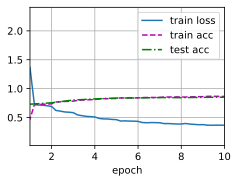

In [10]:
lr, num_epochs = 0.05, 10
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())